# Cluster analysis of organic matter considering carbon and phosphorous fractions

**Objective**:  Classifying composts sixteen horticultural composts collected in Western and Eastern Canada as P fertilizers.

## Import functions and libraries

Import librairies. 

- `numpy` for mathematics
- `pandas` for data tables
- some functions of `scikit-bio` for compositional data transformation
- `altair` and `plotnine` for plots
- `scikit-learn` for clustering metrics and discriminant analysis
- `scipy` for clustering and some statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import altair as alt
from skbio.stats.composition import ilr, clr_inv, ilr_inv
from sklearn import metrics, preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster.hierarchy import *
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

/home/essicolo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We will need custom functions:

- `sbp_basis` to transform a SBP to a computational basis for ilrs,
- `ilrDefinition` to define balance names according to the SBP
- `biplot`, to plot ordination results

In [2]:
%run lib/functions.py

## Import data tables

- data: main data
- sbp: the sequential binary partition used to transform concentrations to balances

In [3]:
data = pd.read_csv('data/data.csv', sep=';', decimal=',')
sbp = pd.read_csv('data/sbp.csv', sep=';')

Remove a line with NaN and arrange data.

In [4]:
data = data.loc[data['Pi-NaHCO3'].notnull(), :].reset_index()

## Compositional data analysis

Identify column names of components.

In [5]:
parts_names = data.columns[7:15]
parts = data.loc[:, parts_names]

Test if their is a concentration cell lower than 0.

In [6]:
np.any(parts < 0)

False

Compute the filling value.

In [7]:
parts['Fv'] = 1E6 - parts.loc[:, parts_names].sum(axis=1)

Check if the parts and the SBP are aligned.

In [8]:
parts.columns

Index(['P-resin', 'Pi-NaHCO3', 'Po-NaHCO3', 'Pi-NaOH', 'Po-NaOH', 'P-HCl',
       'P-residual', 'Carbon', 'Fv'],
      dtype='object')

In [9]:
sbp.columns

Index(['P-resin', 'Pi-NaHCO3', 'Po-NaHCO3', 'Pi-NaOH', 'Po-NaOH', 'P-HCl',
       'P-residual', 'C', 'Fv'],
      dtype='object')

Compute the ilrs (balances).

In [10]:
ilr_coords = pd.DataFrame(ilr(parts, basis=sbp_basis(sbp.as_matrix())))

Define column names.

In [11]:
ilr_no = []
for i in (range(1, 1+ilr_coords.shape[1])):
    ilr_no.append('ilr' + str(i))
ilr_no

['ilr1', 'ilr2', 'ilr3', 'ilr4', 'ilr5', 'ilr6', 'ilr7', 'ilr8']

In [12]:
ilr_coords.columns = ilr_no#ilrDefinition(sbp)

In [13]:
sbp

,P-resin,Pi-NaHCO3,Po-NaHCO3,Pi-NaOH,Po-NaOH,P-HCl,P-residual,C,Fv
0,1,1,1,1,1,1,1,1,-1
1,1,1,-1,1,-1,1,1,0,0
2,0,0,1,0,-1,0,0,0,0
3,1,1,0,-1,0,-1,-1,0,0
4,1,-1,0,0,0,0,0,0,0
5,0,0,0,1,0,-1,-1,0,0
6,0,0,0,0,0,1,-1,0,0
7,1,1,1,1,1,1,1,-1,0


## Data mining



For data mining with `plotnine`, format data table in *tidy* mode.

In [14]:
dat_bal = pd.concat(objs=[data.loc[:, ['Soil', 'Compost']], ilr_coords], axis=1)

In [15]:
dat_melt = pd.melt(dat_bal, id_vars=['Soil', 'Compost'], 
                   var_name='Balance_name', 
                   value_name='Balance_value')

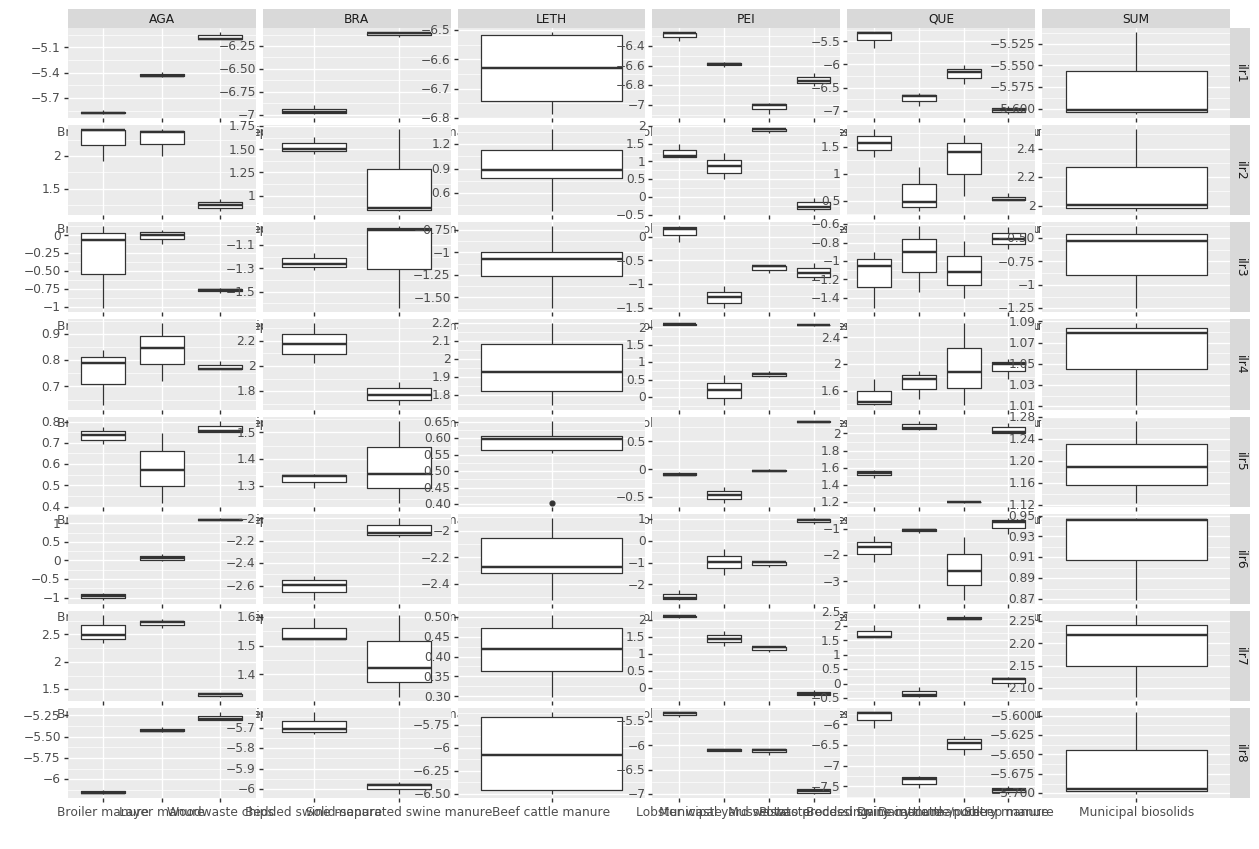

<ggplot: (-9223363282424189110)>

In [16]:
ggplot(dat_melt, aes(x='Compost', y='Balance_value')) +\
    geom_boxplot() +\
    facet_grid('Balance_name ~ Soil', scales='free') +\
    xlab(' ') +\
    ylab(' ') +\
    theme(figure_size=(15, 10))

## Hierachical clustering

Perform the clustering based on the Euclidean distance for different clustering method, select the optimal method and select the optimal/reasonable number of clusters.

Compute the means of ilrs by compost to shrink the table, removing repetitions.

In [17]:
ilr_compost = dat_bal.groupby('Compost').mean()
ilr_compost

,ilr1,ilr2,ilr3,ilr4,ilr5,ilr6,ilr7,ilr8
Compost,,,,,,,,
Bedded swine manure,-6.184955,1.550518,-1.201695,1.849971,1.429236,-2.176773,1.651130,-5.759414
Beef cattle manure,-6.635181,0.916032,-1.130213,1.953775,0.569333,-2.212110,0.412641,-6.063717
Broiler manure,-5.871227,2.240676,-0.321222,0.751746,0.734007,-0.957003,2.565453,-6.151649
Dairy cattle manure,-6.734656,0.633697,-0.954327,1.711245,2.082517,-1.053774,-0.327632,-7.366804
Dairy cattle/poultry manure,-6.200839,1.238757,-1.101702,1.959028,1.201206,-2.535616,2.288170,-6.489634
Layer manure,-5.427619,2.259002,-0.010498,0.835557,0.579432,0.077332,2.708872,-5.418848
Lobster waste,-6.293965,1.255930,0.089099,2.090143,-0.081817,-2.537282,2.098667,-5.351578
Municipal biosolids,-5.572715,2.168249,-0.720362,1.059113,1.195502,0.921072,2.188017,-5.663422
Municipal yard waste,-6.584796,0.864318,-1.281184,0.192775,-0.455874,-0.971523,1.443673,-6.099330


Compute the distance matrix.

In [18]:
distmat = pdist(X=ilr_compost, metric='euclidean')

Compute the clustering for different methods.

In [19]:
clustering_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
clust_l = []
coph_corr_l = []
for i in range(len(clustering_methods)):
    clust_m = linkage(y=distmat, method=clustering_methods[i])
    clust_l.append(clust_m)
    coph_corr_l.append(cophenet(clust_m, pdist(ilr_compost))[0])

# create a dictionnary with lists
clust_d = dict(zip(clustering_methods, clust_l))
coph_corr_d = dict(zip(clustering_methods, coph_corr_l))

# create a data frame with the dictionnary
coph_corr_df = pd.DataFrame(coph_corr_d, index=[0]).melt()

The best clustering method is the one returning the highest cophenetic correlation.

In [20]:
best_method = coph_corr_df.loc[coph_corr_df['value'] == coph_corr_df['value'].max(), 'variable'].values
best_method = str(best_method[0])
best_method_i = np.where(np.array(clustering_methods) == best_method)[0][0]
coph_corr_df['Is best'] = coph_corr_df['variable'] == best_method

In [21]:
alt.Chart(coph_corr_df).mark_bar().encode(
    x=alt.X('value', title='Cophenetic correlation'), 
    y=alt.Y('variable', title='Method'), color='Is best')

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


To determine the optimal/reasonable number of clusters, we examine the fusion level plot as well as the silouhette plot.

In [22]:
heights = clust_d[best_method][:, 2]

In [23]:
silhouette = []
n_clust = list(range(2, len(heights)))
for i in n_clust:
    nodes_f = fcluster(Z=clust_d[best_method], t=i, criterion='maxclust') # criterion = 'distance'
    silhouette.append(metrics.silhouette_score(squareform(distmat), nodes_f, metric='euclidean'))

In [24]:
n_clust_smax = np.array(n_clust)[silhouette == np.max(silhouette)]
silhouette_smax = np.array(silhouette)[silhouette == np.max(silhouette)]

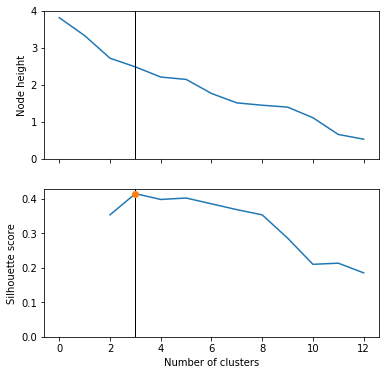

In [25]:
f, axarr = plt.subplots(2, sharex=True, figsize=(6, 6))
axarr[0].plot(list(range(len(heights)))[::-1], heights)
axarr[0].set_ylabel('Node height')
axarr[0].axvline(x=3, c='k', linewidth=1)
axarr[0].set_ylim([0, 4])
axarr[1].plot(n_clust, silhouette)
axarr[1].axvline(x=3, c='k', linewidth=1)
axarr[1].plot(n_clust_smax, silhouette_smax, 'o')
axarr[1].set_xlabel('Number of clusters')
axarr[1].set_ylabel('Silhouette score')
axarr[1].set_ylim([0, 0.43])
plt.savefig('fusionlevel&silhouette.png', dpi=300)

The fusion level plot (top) shows that the height diminishes rather constantly with increasing number of clusters: composts shows large dissimilarities between them. However, the silouhette score reaches its maximum with 3 clusters. The choice of 3 clusters is reasonable.

Create the dendrogram.

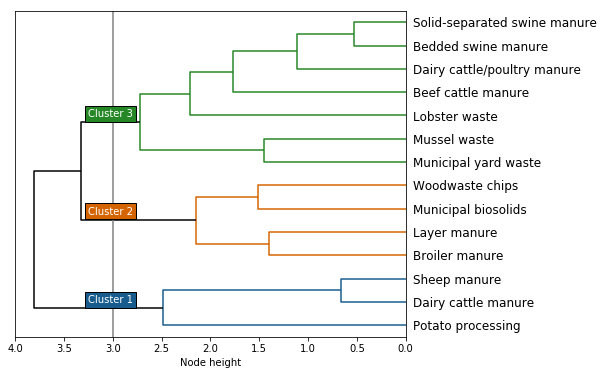

In [26]:
palette = ['#175c8d', '#d46400', '#258725']
set_link_color_palette(palette)
plt.figure(figsize=(7, 6))
dendrogram(clust_d[best_method], orientation='left',
           color_threshold=3, labels=ilr_compost.index,
           above_threshold_color='black')
plt.axvline(x=3, c='grey')
plt.xlabel('Node height')
plt.text(3.25, 14.5, 'Cluster 1', bbox={'facecolor':palette[0], 'alpha':1, 'pad':3}, color='white')
plt.text(3.25, 52.5, 'Cluster 2', bbox={'facecolor':palette[1], 'alpha':1, 'pad':3}, color='white')
plt.text(3.25, 94.5, 'Cluster 3', bbox={'facecolor':palette[2], 'alpha':1, 'pad':3}, color='white')
plt.savefig('cluster-dendrogram.png', dpi=100, bbox_inches='tight', pad_inches=0.5)

The cluster number for each compost is identified with variable `nodes_f`.

In [27]:
nodes_f = fcluster(Z=clust_d[best_method], t=3, criterion='maxclust')

In [28]:
ilr_compost['Cluster'] = nodes_f
ilr_compost_i = ilr_compost.reset_index()

Join the cluster name to the main data table, then export the table in csv for data sharing.

In [29]:
data = pd.merge(left=data, right=ilr_compost_i[['Compost', 'Cluster']], on='Compost')

In [30]:
data.to_csv('cluster.csv', sep=';')

We also export some statistics concerning clusters.

In [31]:
clus_mean_bal = ilr_compost_i.groupby('Cluster').mean()

In [32]:
clus_mean_bal

,ilr1,ilr2,ilr3,ilr4,ilr5,ilr6,ilr7,ilr8
Cluster,,,,,,,,
1,-6.821603,0.314911,-0.817634,1.910805,1.663501,-0.317203,-0.136440,-7.294699
2,-5.461321,1.978793,-0.454735,0.855851,0.819862,0.286128,2.214732,-5.625809
3,-6.434994,1.262940,-0.925297,1.497022,0.573719,-1.941014,1.498638,-5.982297


In [33]:
clus_means = ilr_inv(clus_mean_bal.as_matrix(),
                     basis=sbp_basis(sbp.as_matrix()))
clus_means = pd.DataFrame(clus_means, columns=sbp.columns, index=clus_mean_bal.index)
clus_means

,P-resin,Pi-NaHCO3,Po-NaHCO3,Pi-NaOH,Po-NaOH,P-HCl,P-residual,C,Fv
Cluster,,,,,,,,,
1,0.001624,0.000155,0.000076,0.000068,0.000241,0.000090,0.000110,0.397530,0.600107
2,0.004096,0.001285,0.000199,0.001327,0.000378,0.004474,0.000195,0.366055,0.621992
3,0.001731,0.000769,0.000092,0.000060,0.000340,0.001875,0.000225,0.225131,0.769776


In [34]:
clus_means.to_csv('clus_means.csv', sep=';')

## Linear discriminant analysis

In order to assess which balance is responsible of the difference between clusters, we can perform a linear discriminant analysis. But first, let's examine the data among clusters.

In [35]:
dat_bal_clust = pd.merge(left=dat_bal, right=ilr_compost_i[['Compost', 'Cluster']], on='Compost')

In [36]:
dat_melt_clust = pd.melt(dat_bal_clust, id_vars=['Soil', 'Compost', 'Cluster'], 
                   var_name='Balance_name', 
                   value_name='Balance_value')
ilrdef_df = pd.DataFrame({'Balance_name': ilr_no, 'ilr_definition': ilrDefinition(sbp)})
dat_melt_clust = pd.merge(left=dat_melt_clust, right=ilrdef_df, on='Balance_name')
dat_melt_clust['Cluster'] = dat_melt_clust['Cluster'].astype('category')
dat_melt_clust.head()

,Soil,Compost,Cluster,Balance_name,Balance_value,ilr_definition
0,PEI,Lobster waste,3,ilr1,-6.271528,"[Fv | C,P-residual,P-HCl,Po-NaOH,Pi-NaOH,Po-Na..."
1,PEI,Lobster waste,3,ilr1,-6.259912,"[Fv | C,P-residual,P-HCl,Po-NaOH,Pi-NaOH,Po-Na..."
2,PEI,Lobster waste,3,ilr1,-6.350455,"[Fv | C,P-residual,P-HCl,Po-NaOH,Pi-NaOH,Po-Na..."
3,PEI,Mussel waste,3,ilr1,-6.985974,"[Fv | C,P-residual,P-HCl,Po-NaOH,Pi-NaOH,Po-Na..."
4,PEI,Mussel waste,3,ilr1,-7.093334,"[Fv | C,P-residual,P-HCl,Po-NaOH,Pi-NaOH,Po-Na..."


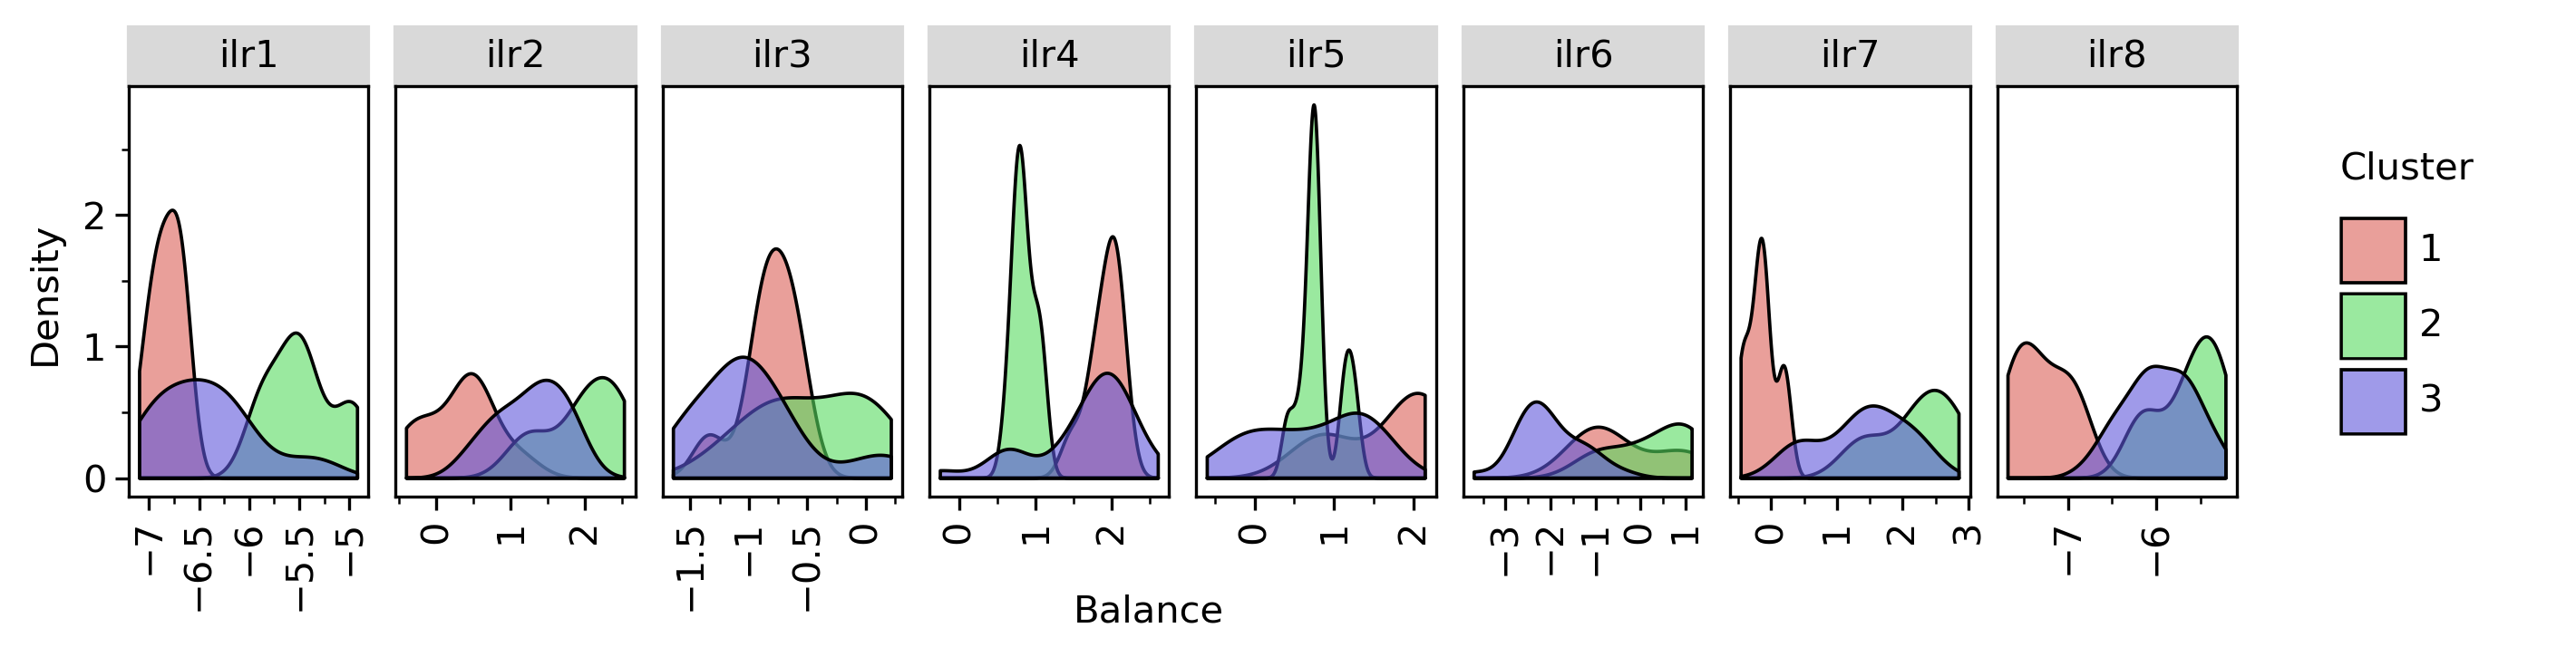

<ggplot: (-9223363282428926937)>

In [37]:
ggplot(dat_melt_clust, aes(x='Balance_value')) + \
    geom_density(aes(fill='Cluster'), alpha=0.6) +\
    facet_grid('. ~ Balance_name', scales='free_x')  +\
    xlab('Balance') +\
    ylab('Density') +\
    theme_matplotlib() +\
    theme(axis_text_x=element_text(angle=90),
         figure_size = (10, 2), dpi=300)

We are using `scikit-learn`. To perform a classical LDA, we need to fist standardize our data (mean=0, sd=1). Then we solve the problem using eigen values (`solver='eigen'`).

In [38]:
ilr_s = preprocessing.scale(ilr_coords, axis=0)

In [39]:
lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen')
lda.fit(X=ilr_s, y=data['Cluster'])

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)

Extract the information from the LDA.

In [40]:
objects_lda = lda.transform(ilr_s)
eigenvectors_lda = lda.scalings_.T
eigenvalues_lda = lda.explained_variance_ratio_
labels = ilr_no#ilrDefinition(sbp)

Run the biplot.

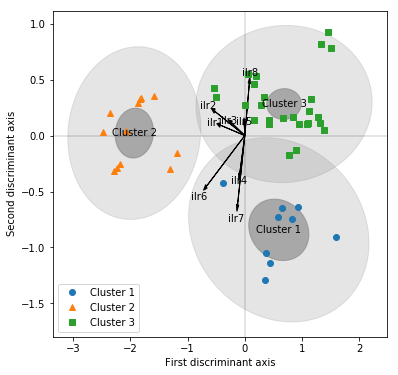

In [41]:
plt.figure(figsize=(6, 6))
biplot(objects=objects_lda,
       eigenvectors=eigenvectors_lda,
       labels=labels,
       group='Cluster ' + data['Cluster'].astype(str),
       plot_ellipses=True)
plt.xlabel('First discriminant axis')
plt.ylabel('Second discriminant axis')
plt.legend()
plt.savefig('ad.png', dpi=300)

Ellipses are not representative of the spread of data scores. Plus we should use a way to differenciate composts. Let's use a more custom plot with `plotnine`.

In [42]:
gg_data = pd.concat([data[['Compost', 'Cluster']], 
                     pd.DataFrame(objects_lda, columns=['LDA1', 'LDA2'])], 
                    axis=1)
gg_data['Cluster'] = 'Cluster ' + gg_data['Cluster'].astype(str)
abreviations = pd.DataFrame({'Compost': data.Compost.unique(), 
                             'abreviation': ['LW', 'MW', 'PP', 'MYW', 'BSM', 'DCM', 
                                             'ShM', 'DCPM', 'SSM', 'BCM', 'MB', 'BM', 
                                             'WC', 'LM']})
gg_data = pd.merge(gg_data, abreviations, on='Compost')
gg_data['Compost'] = gg_data.abreviation + ': ' + gg_data.Compost

loadings = pd.DataFrame(eigenvectors_lda[[0, 1], :],
                        columns=ilr_no, index=['LDA1', 'LDA2']).T


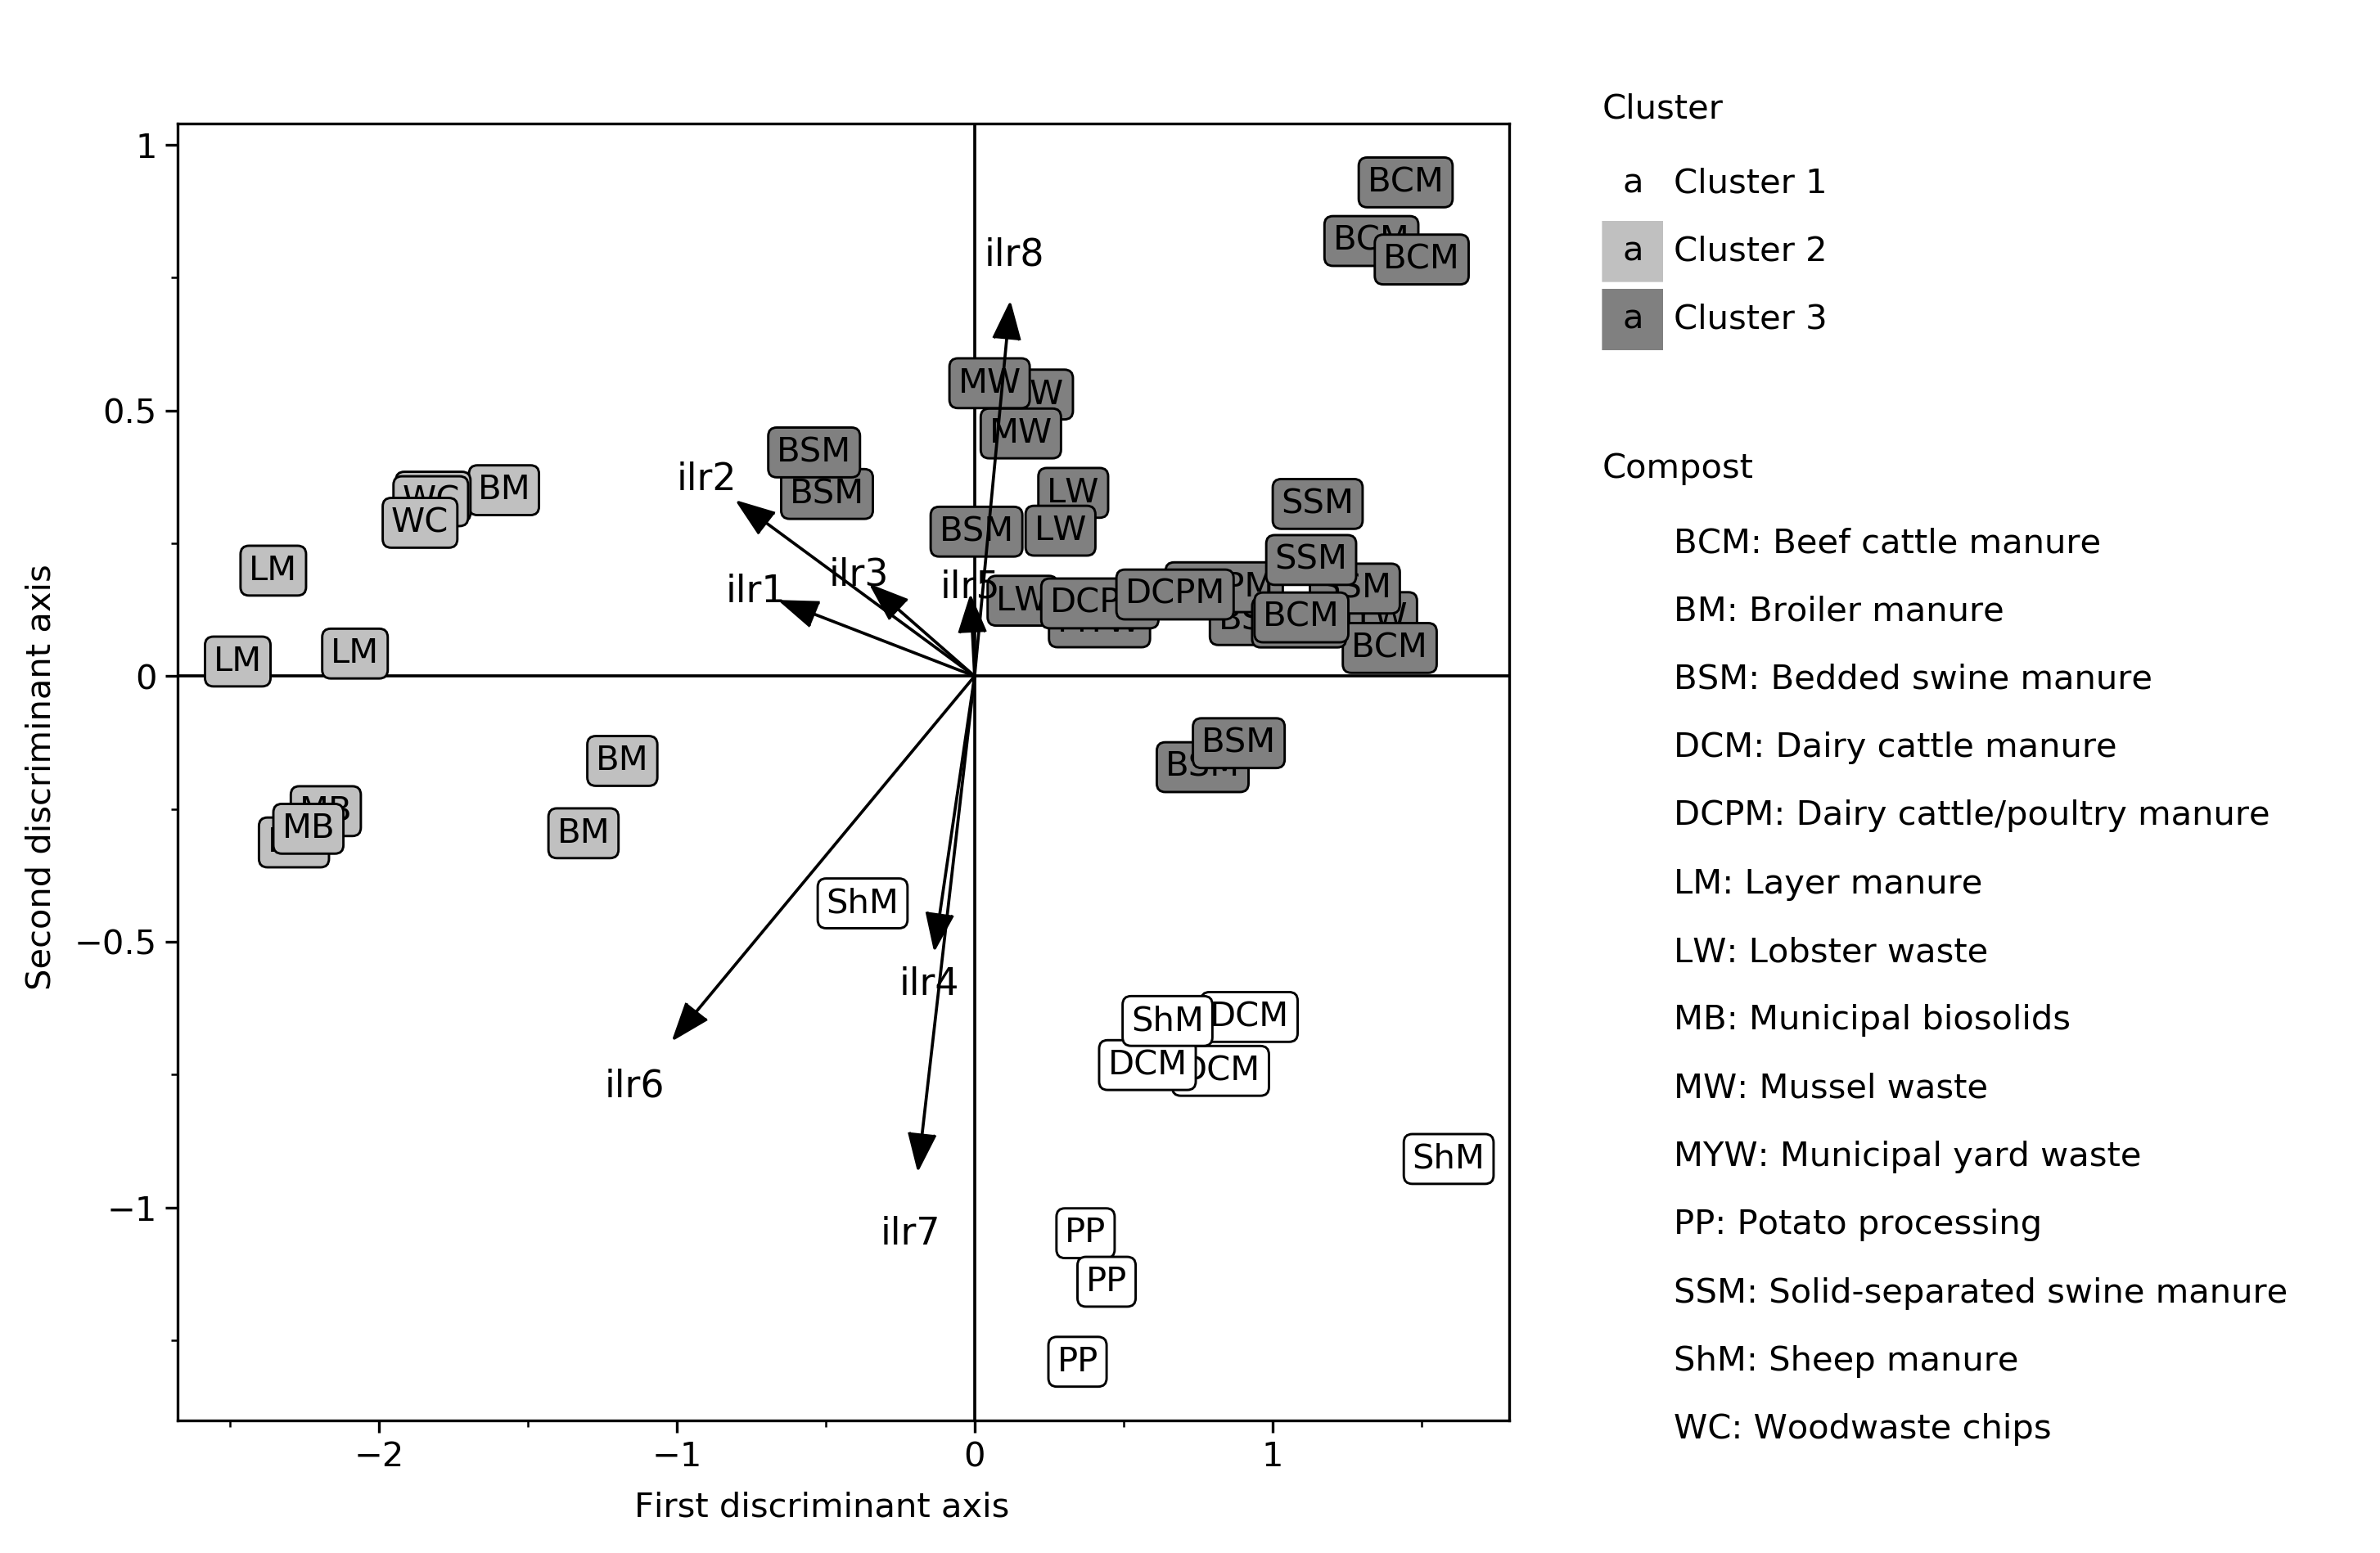

<ggplot: (-9223363282431396685)>

In [43]:
ggplot(gg_data, aes(x='LDA1', y='LDA2')) +\
    geom_vline(xintercept=0) +\
    geom_hline(yintercept=0) +\
    geom_point(aes(color='Compost')) +\
    geom_label(aes(fill='Cluster', label='abreviation'), size=10) +\
    geom_segment(data=loadings*1.5, x=0, y=0, 
                 mapping=aes(xend='LDA1', yend='LDA2'),
                arrow=arrow(angle=20, length=0.2, type='closed')) +\
    geom_text(data=(loadings*1.7).reset_index(),
                 mapping=aes(label='index')) +\
    xlab('First discriminant axis') +\
    ylab('Second discriminant axis') +\
    scale_color_manual(np.repeat('white', abreviations.shape[0])) +\
    scale_fill_manual(['white', 'silver', 'grey']) +\
    theme_matplotlib() +\
    theme(figure_size = (7, 7), dpi=300)